In [6]:
!pip install pmdarima


In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima.arima import auto_arima
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/somecode ML'
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings
warnings.filterwarnings('ignore')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/somecode ML


In [4]:
# dateparse = lambda dates: pd.to_datetime(dates, format='%m/%d/%Y %M:%S')
mydata = pd.read_csv('FPT.csv',index_col='Date/Time')

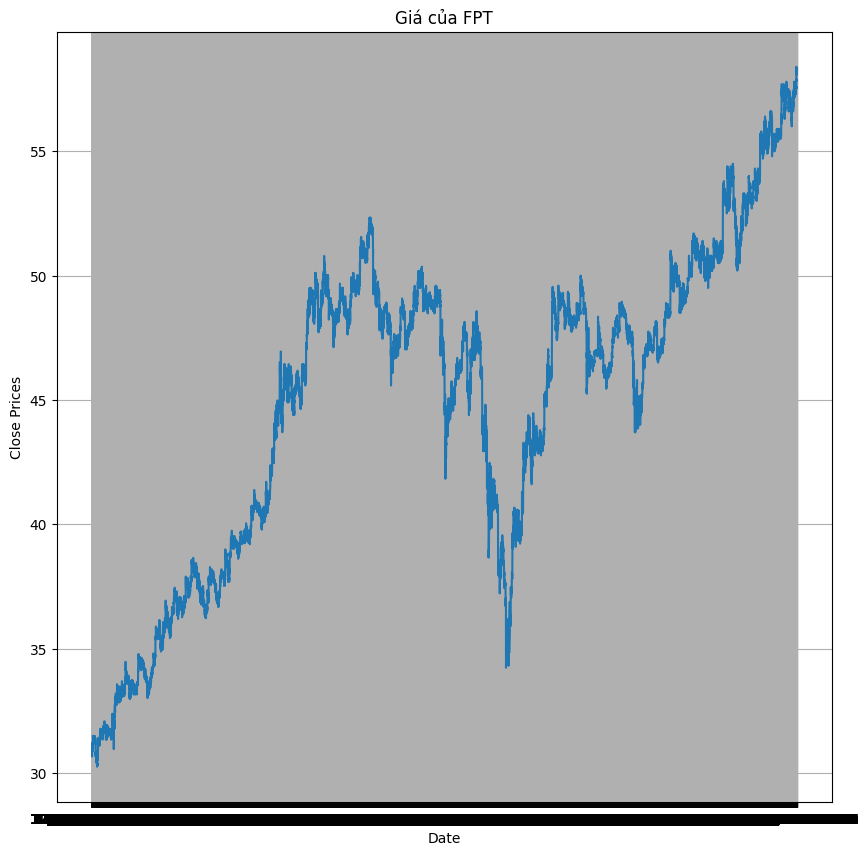

In [9]:
plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(mydata['Close'])
plt.title('Giá của FPT')
plt.show()

In [5]:
def test_stationarity(timeseries):
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(mydata['Close'])

Test Statistics                   -1.345307
p-value                            0.608198
No. of lags used                  29.000000
Number of observations used    97376.000000
critical value (1%)               -3.430417
critical value (5%)               -2.861570
critical value (10%)              -2.566786
dtype: float64


In [11]:
from statsmodels.tsa.statespace.tools import diff
d_mydatad=diff(mydata['Close'])
test_stationarity(d_mydatad)

Test Statistics                  -62.647234
p-value                            0.000000
No. of lags used                  28.000000
Number of observations used    97376.000000
critical value (1%)               -3.430417
critical value (5%)               -2.861570
critical value (10%)              -2.566786
dtype: float64


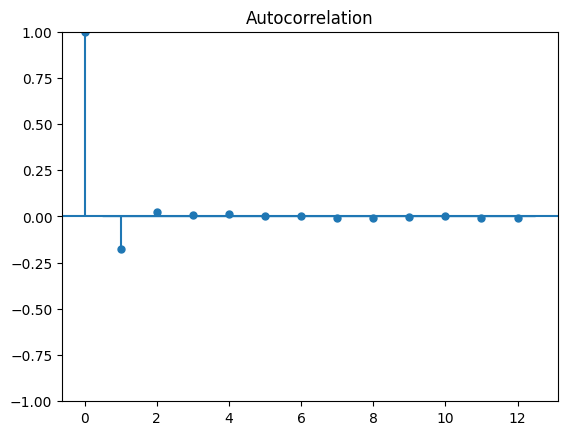

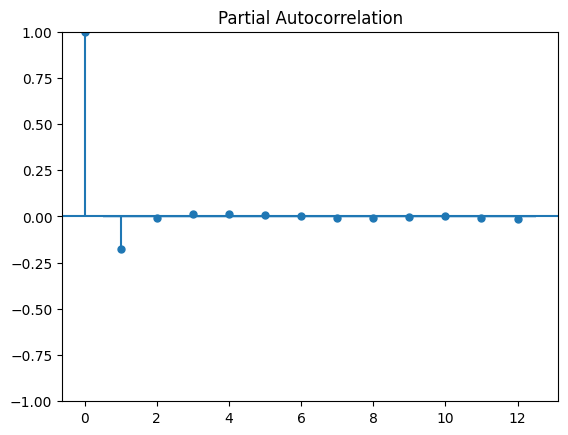

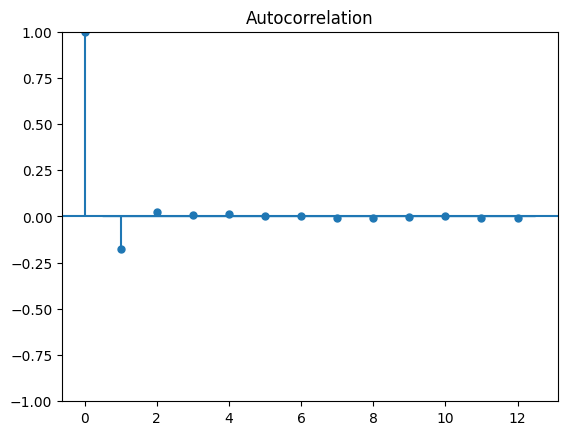

In [12]:
plot_pacf(d_mydatad,lags=12)
plot_acf(d_mydatad,lags=12)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-260655.242, Time=33.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-263642.366, Time=27.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-263583.033, Time=25.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-260655.356, Time=15.54 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-263645.767, Time=26.66 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-263656.783, Time=23.26 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-263678.038, Time=23.91 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-263677.834, Time=46.79 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-263657.826, Time=24.83 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-263677.460, Time=21.87 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0] intercept
Total fit time: 268.788 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                97406
Model:              

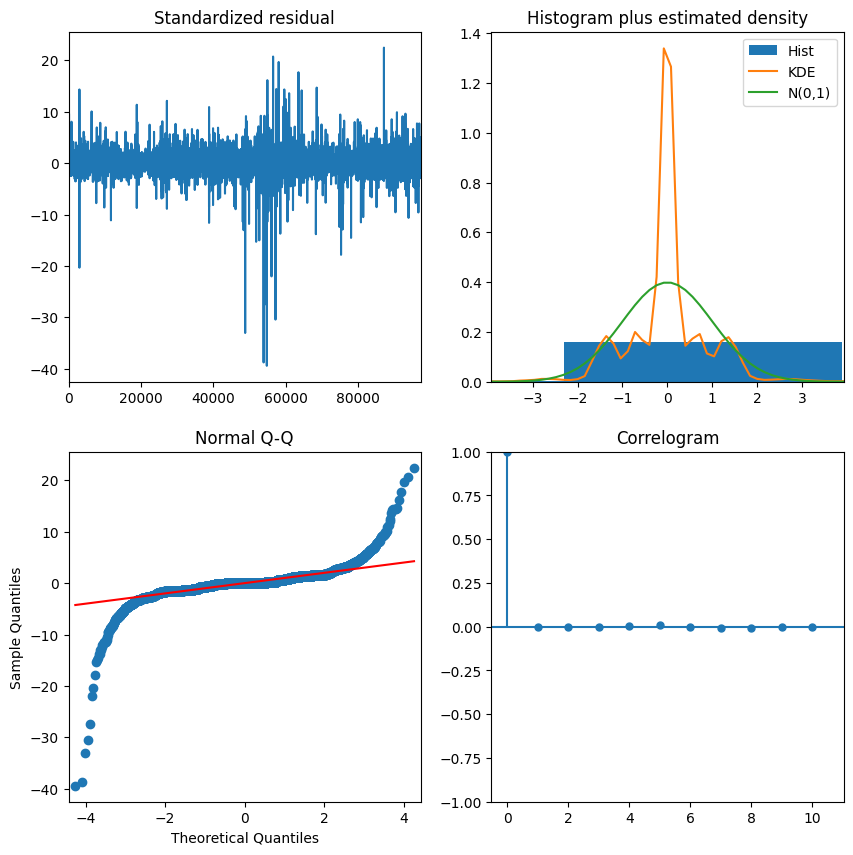

In [13]:
model_autoARIMA = auto_arima(mydata['Close'], start_p=0, start_q=0,
                      max_p=4, max_q=4,  # p tối đa và q tối đa
                      start_P=0,
                      d=1,
                      D=0,seasonal=False,
                      trace=True,
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(10,10))
plt.show()

       Chi-Sq  Prob>Chi-Sq         F    Prob>F
1    0.354713     0.551458  0.354707  0.551462
2    0.747599     0.688115  0.373791  0.688122
3    0.756059     0.859946  0.252011  0.859951
4    0.773080     0.942020  0.193262  0.942024
5    1.251815     0.939811  0.250351  0.939816
6    1.643595     0.949392  0.273917  0.949397
7    7.252758     0.403046  1.036100  0.403060
8    7.397691     0.494394  0.924696  0.494413
9    7.398260     0.595729  0.822007  0.595751
10   7.485378     0.678964  0.748511  0.678988
11   9.249355     0.598888  0.840827  0.598913
12  10.239838     0.594929  0.853296  0.594955
   Jung-Box   JB-P-val Box-Pierce   BP-P-val
1   lb_stat  lb_pvalue    bp_stat  bp_pvalue
2   lb_stat  lb_pvalue    bp_stat  bp_pvalue
3   lb_stat  lb_pvalue    bp_stat  bp_pvalue
4   lb_stat  lb_pvalue    bp_stat  bp_pvalue
5   lb_stat  lb_pvalue    bp_stat  bp_pvalue
6   lb_stat  lb_pvalue    bp_stat  bp_pvalue
7   lb_stat  lb_pvalue    bp_stat  bp_pvalue
8   lb_stat  lb_pvalue    bp_

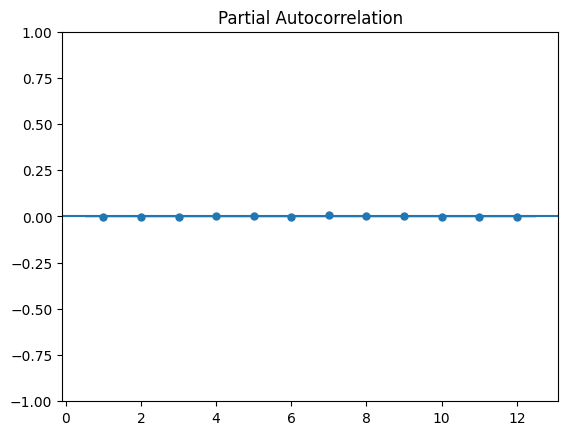

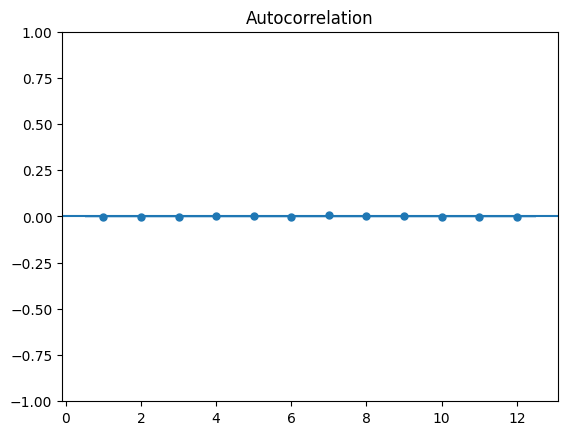

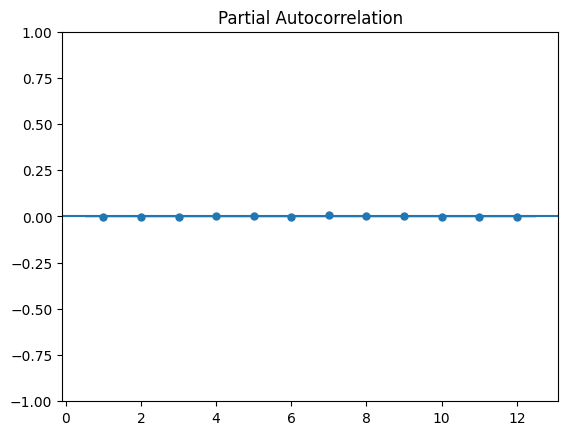

In [15]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
model = ARIMA(mydata['Close'], order=(4,1,0))
fitted = model.fit()
fitted.summary()
resids= fitted.resid
lags=12

### Kiểm định tương quan chuỗi BG
chi2=np.zeros(lags)
probChi2=np.zeros(lags)
F=np.zeros(lags)
probf=np.zeros(lags)
for i in range(lags):
    chi2[i],probChi2[i],F[i],probf[i] = sm.stats.diagnostic.acorr_breusch_godfrey(fitted,i+1)
BG_test = pd.DataFrame({'Chi-Sq': chi2, 'Prob>Chi-Sq': probChi2,
                        'F': F, 'Prob>F': probf}, index=range(1,lags+1))
print(BG_test)


### Kiểm định tương quan chuỗi Ljing-Box test

lags =12  # required for the following tests
jb, jbpv, bp, bppv = sm.stats.diagnostic.acorr_ljungbox(resids,lags,True,return_df=False)
JB_test = pd.DataFrame({'Jung-Box': jb,
                    'JB-P-val': jbpv,
                   'Box-Pierce': bp,
                   'BP-P-val': bppv},
                   index=range(1,lags+1))
print(JB_test)


# check for residual autocorrelation ACF and PACF
import statsmodels.graphics.tsaplots as tsaplt
import statsmodels.tsa.api as tsa

acf, acf_confint, lbq, lbqpv = tsa.acf(resids, nlags=lags, alpha=0.05, qstat=True, fft=False)
pacf, pacf_confint = tsa.pacf(resids, nlags=lags, alpha=0.05)
acf_se = (acf_confint[:,1]-acf)/1.96
pacf_se = (pacf_confint[:,1]-pacf)/1.96

ACF_table = pd.DataFrame({'AR': acf[1:], 'AR_se': acf_se[1:],
                          'PAR': pacf[1:], 'PAR_se': pacf_se[1:],
                          'Ljung-Box Q': lbq, 'Q_pval': lbqpv},
                    index=range(1,lags+1))
print(ACF_table)

# plots of ACF and Pacf
tsaplt.plot_acf(fitted.resid, lags=lags, zero=False)
tsaplt.plot_pacf(fitted.resid, lags=lags, zero=False)





In [16]:

predictions = fitted.predict(start=0, end=97400, dynamic=False).rename('ARIMA(4,1,0) Dự báo')
for i in range(len(predictions)):
    print(f"Giá trị dự báo={predictions[i]:<11.10}, Giá trị thực tế={mydata['Close'][i]}")
title = 'Kết quả dự báo trong mẫu'


Streaming output truncated to the last 5000 lines.
Giá trị dự báo=46.00071483, Giá trị thực tế=45.95
Giá trị dự báo=45.95953503, Giá trị thực tế=45.95
Giá trị dự báo=45.95026541, Giá trị thực tế=45.95
Giá trị dự báo=45.94928517, Giá trị thực tế=45.95
Giá trị dự báo=45.9492261 , Giá trị thực tế=45.95
Giá trị dự báo=45.95      , Giá trị thực tế=45.95
Giá trị dự báo=45.95      , Giá trị thực tế=45.95
Giá trị dự báo=45.95      , Giá trị thực tế=45.95
Giá trị dự báo=45.95      , Giá trị thực tế=45.95
Giá trị dự báo=45.95      , Giá trị thực tế=46.0
Giá trị dự báo=45.99123887, Giá trị thực tế=46.0
Giá trị dự báo=45.99973459, Giá trị thực tế=46.0
Giá trị dự báo=46.00071483, Giá trị thực tế=46.0
Giá trị dự báo=46.0007739 , Giá trị thực tế=46.0
Giá trị dự báo=46.0       , Giá trị thực tế=46.0
Giá trị dự báo=46.0       , Giá trị thực tế=46.1
Giá trị dự báo=46.08247773, Giá trị thực tế=46.15
Giá trị dự báo=46.14070804, Giá trị thực tế=46.2
Giá trị dự báo=46.19240312, Giá trị thực tế=46.2
Giá trị 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Giá trị dự báo=55.2156799 , Giá trị thực tế=55.3
Giá trị dự báo=55.28134264, Giá trị thực tế=55.2
Giá trị dự báo=55.21710957, Giá trị thực tế=55.2
Giá trị dự báo=55.2004127 , Giá trị thực tế=55.3
Giá trị dự báo=55.28259586, Giá trị thực tế=55.2
Giá trị dự báo=55.21544365, Giá trị thực tế=55.3
Giá trị dự báo=55.28443822, Giá trị thực tế=55.1
Giá trị dự báo=55.13463184, Giá trị thực tế=55.1
Giá trị dự báo=55.10094352, Giá trị thực tế=55.1
Giá trị dự báo=55.09868846, Giá trị thực tế=55.1
Giá trị dự báo=55.09690441, Giá trị thực tế=55.2
Giá trị dự báo=55.18247773, Giá trị thực tế=55.1
Giá trị dự báo=55.11699144, Giá trị thực tế=55.1
Giá trị dự báo=55.10196049, Giá trị thực tế=55.1
Giá trị dự báo=55.10011813, Giá trị thực tế=55.1
Giá trị dự báo=55.09845221, Giá trị thực tế=55.2
Giá trị dự báo=55.18247773, Giá trị thực tế=55.1
Giá trị dự báo=55.11699144, Giá trị thực tế=55.1
Giá trị dự báo=55.10196049, Giá trị thực tế=55.1
Giá trị dự báo=55.

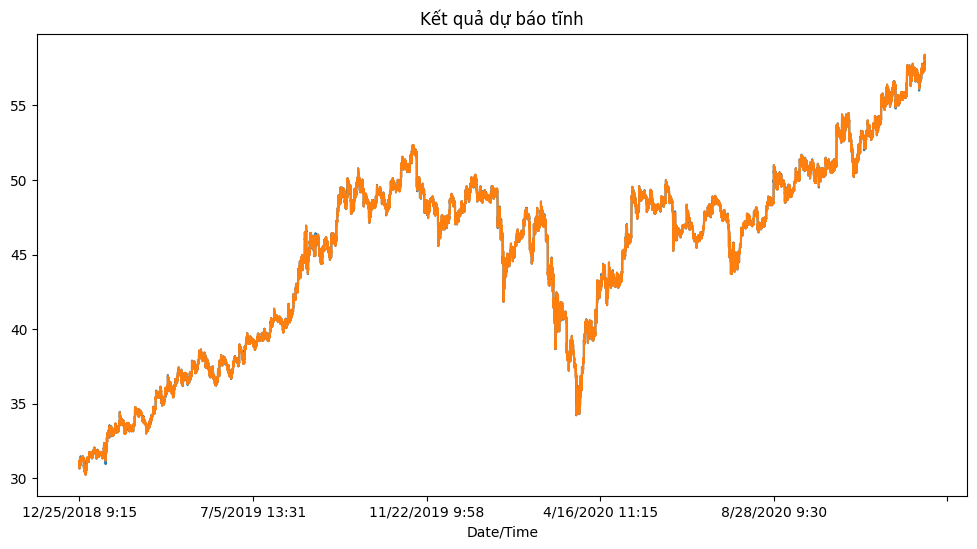

In [17]:
dynamic = fitted.predict(start=1, end=97406, dynamic=False).rename('ARIMA(4,1,0) Forecast')
title = 'Kết quả dự báo tĩnh'
xlabel='Week'
ax = mydata['Close'].plot(legend=False,figsize=(12,6),title=title)
dynamic.plot(legend=False)
ax.autoscale(axis='x',tight=False)


In [18]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

MSE = mean_squared_error(mydata['Close'], dynamic)
RMSE = rmse(mydata['Close'], dynamic)
MAE = mean_absolute_error(mydata['Close'], dynamic)
MAPE = np.mean(np.abs(dynamic - mydata['Close'])/np.abs(mydata['Close']))
print(f'ARIMA(0,1,0) MSE : {MSE:11.10}')
print(f'ARIMA(0,1,0) RMSE : {RMSE:11.10}')
print(f'ARIMA(0,1,0) MAE : {MAE:11.10}')
print(f'ARIMA(0,1,0) MAPE : {MAPE:11.10}')


ARIMA(0,1,0) MSE : 0.0001234736888
ARIMA(0,1,0) RMSE : 0.01111187153
ARIMA(0,1,0) MAE : 0.00623411718
ARIMA(0,1,0) MAPE :         nan


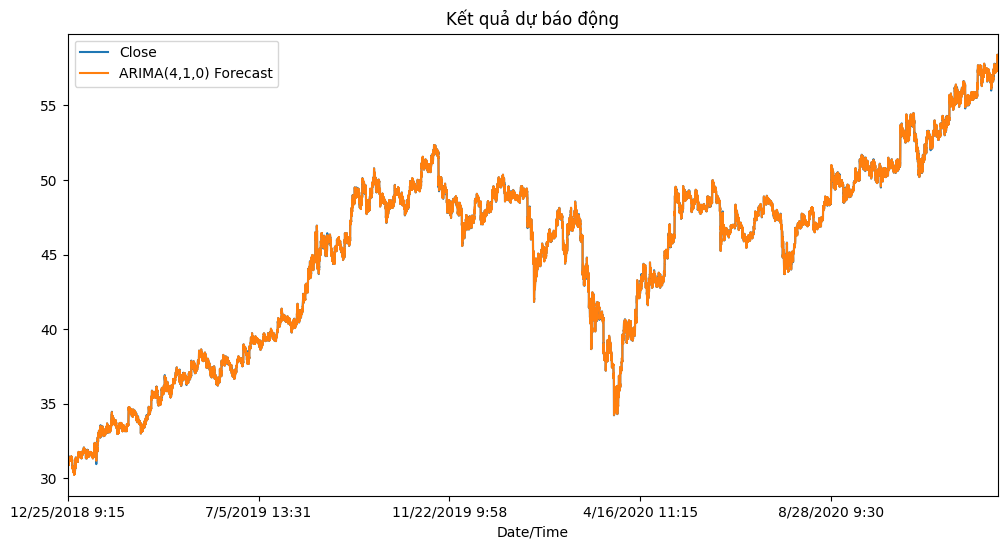

In [19]:
static = fitted.predict(start=1, end=97406, dynamic=False).rename('ARIMA(4,1,0) Forecast')
title = 'Kết quả dự báo động'
xlabel='Week'

ax = mydata['Close'].plot(legend=True,figsize=(12,6),title=title)
static.plot(legend=True)
ax.autoscale(axis='x',tight=True)


In [20]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

MSE = mean_squared_error(mydata['Close'], static)
RMSE = rmse(mydata['Close'], static)
MAE = mean_absolute_error(mydata['Close'], static)
MAPE = np.mean(np.abs(static - mydata['Close'])/np.abs(mydata['Close']))
print(f'ARIMA(4,1,0) MSE : {MSE:11.10}')
print(f'ARIMA(4,1,0) RMSE : {RMSE:11.10}')
print(f'ARIMA(4,1,0) MAE : {MAE:11.10}')
print(f'ARIMA(4,1,0) MAPE : {MAPE:11.10}')

ARIMA(4,1,0) MSE : 0.0001234736888
ARIMA(4,1,0) RMSE : 0.01111187153
ARIMA(4,1,0) MAE : 0.00623411718
ARIMA(4,1,0) MAPE :         nan


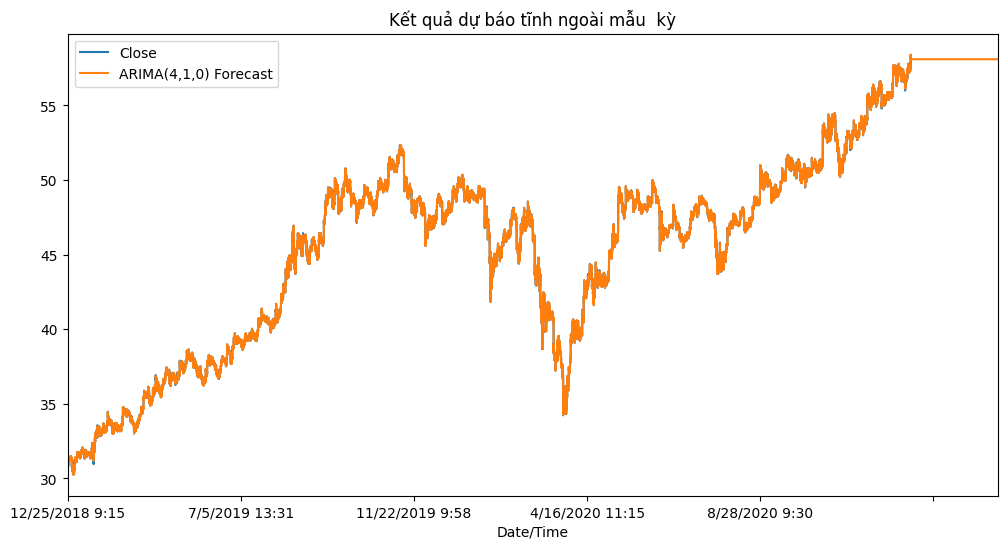

In [21]:
dynamic = fitted.predict(start=1, end=97406+10000, dynamic=False).rename('ARIMA(4,1,0) Forecast')
title = 'Kết quả dự báo tĩnh ngoài mẫu  kỳ'
xlabel='Week'

ax = mydata['Close'].plot(legend=True,figsize=(12,6),title=title)
dynamic.plot(legend=True)
ax.autoscale(axis='x',tight=True)


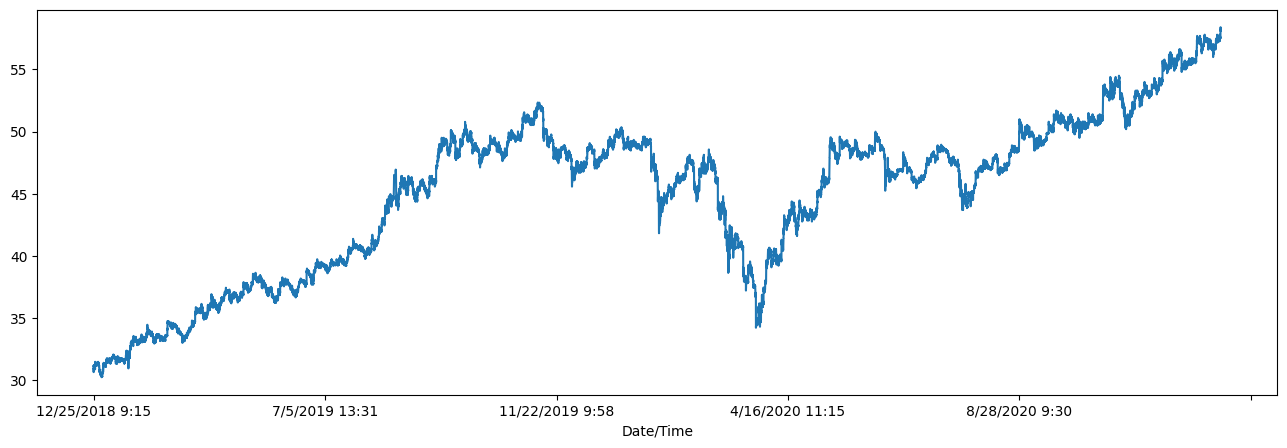

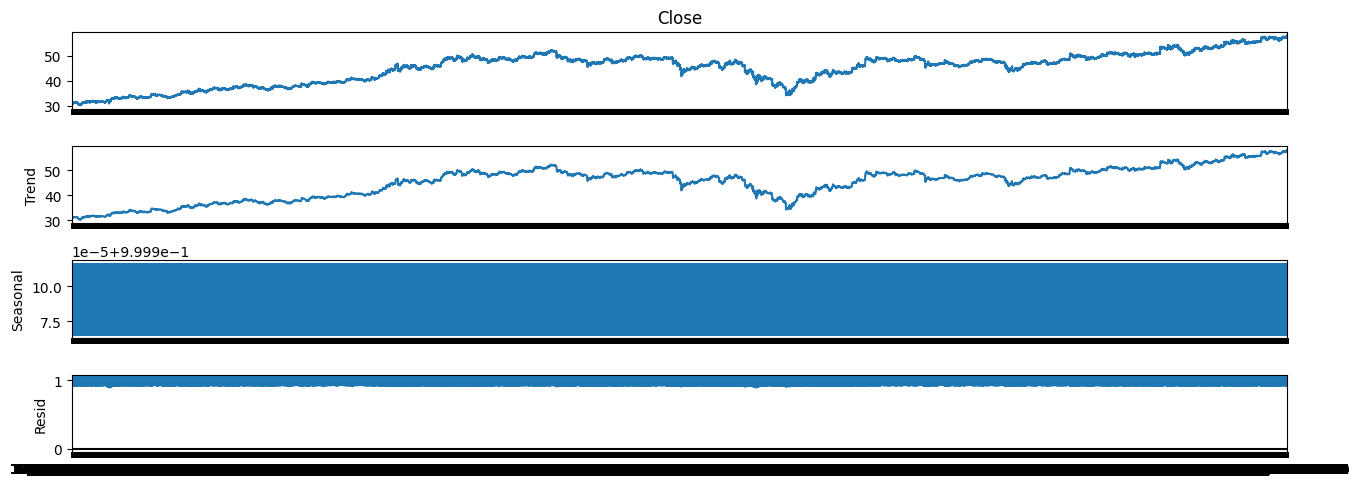

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
data36month = pd.read_csv('FPT.csv', index_col='Date/Time')
data36month['Close'].plot(figsize=(16, 5))
result = seasonal_decompose(data36month['Close'], model='multiplicative', period=12)
fig = result.plot()
fig.set_size_inches(16, 5)

Test Statistics                   -1.345307
p-value                            0.608198
No. of lags used                  29.000000
Number of observations used    97376.000000
critical value (1%)               -3.430417
critical value (5%)               -2.861570
critical value (10%)              -2.566786
dtype: float64


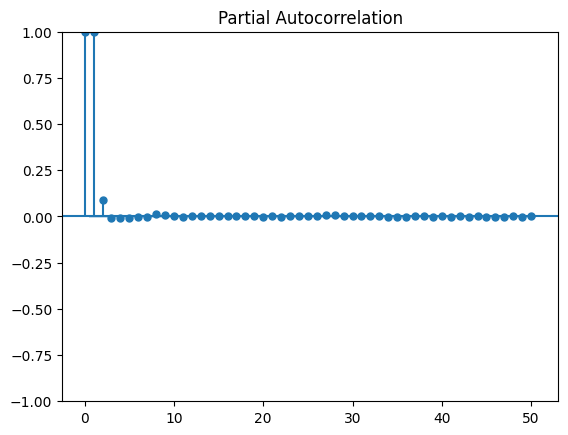

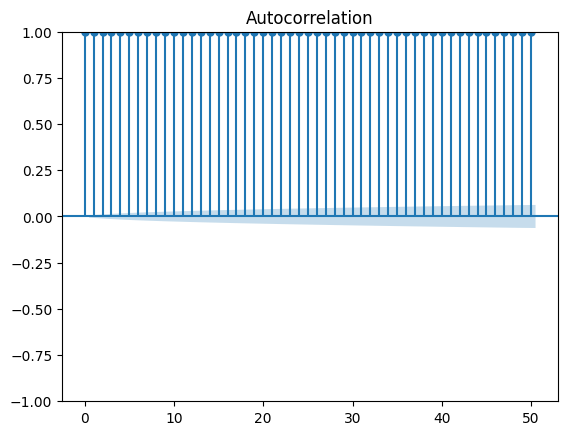

In [10]:
plot_pacf(data36month['Close'])
plot_acf(data36month['Close'])
test_stationarity(data36month['Close'])


Test Statistics                  -62.647234
p-value                            0.000000
No. of lags used                  28.000000
Number of observations used    97376.000000
critical value (1%)               -3.430417
critical value (5%)               -2.861570
critical value (10%)              -2.566786
dtype: float64


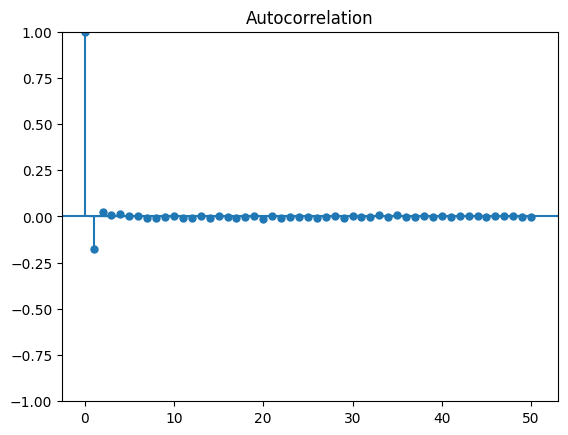

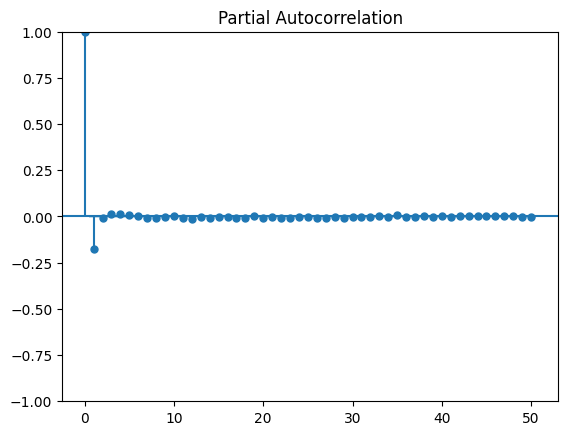

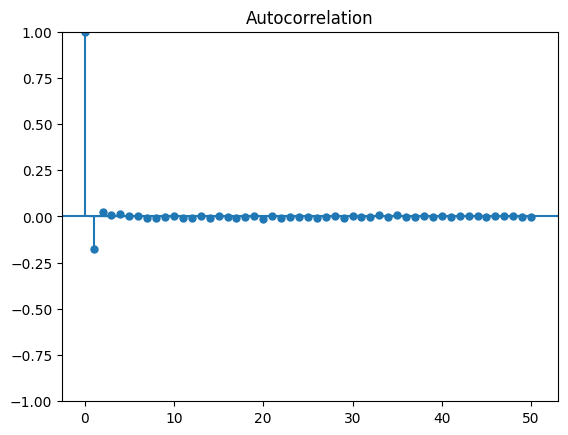

In [12]:
from statsmodels.tsa.statespace.tools import diff
d_data36month=diff(data36month['Close'])
test_stationarity(d_data36month)
plot_pacf(d_data36month)
plot_acf(d_data36month)

In [13]:
model_sarima = auto_arima(data36month['Close'], start_p=0, start_q=0,
                           max_p=5, max_q=5, m=False,
                           start_P=False, seasonal=False,
                           d=1, D=False, trace=False,
                           error_action='ignore',
                           suppress_warnings=False,
                           stepwise=False)




model_sarima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                97406
Model:               SARIMAX(0, 1, 4)   Log Likelihood              131847.987
Date:                Sat, 18 Nov 2023   AIC                        -263683.973
Time:                        17:56:14   BIC                        -263627.054
Sample:                             0   HQIC                       -263666.679
                              - 97406                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      1.559      0.119   -7.15e-05       0.001
ma.L1         -0.1756      0.001   -160.462      0.000      -0.178      -0.173
ma.L2          0.0254      0.002     13.915      0.000       0.022       0.029
ma.L3          0.0110      0.002      5.390      0.000       0.007       0.015
ma.L4          0.0123      0.002      5.192      0.000       0.008       0.017
sigma2         0.0039   2.63e-06   1484.580      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          42759290.71
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                            -1.95
Prob(H) (two-sided):                  0.00   Kurtosis:                       105.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""